# Creating a QSPR model

You can download example data sets from [this link](https://drive.google.com/file/d/1lYOmQBnAawnDR2Kwcy8yVARQTVzYDelw/view?usp=sharing). Just unpack the file in this folder and you should be good to go. For the sake of simplicity, this tutorial uses a small set of only 500 compounds (files with the `small` suffix), but the full sets (without a suffix) are also available.

## Pre-processing your dataset

### Converting data into the right format
First your dataset needs to be in the right format.
It has to have a least a column containing SMILES sequences, as well as a column for each of the properties you want
to predict, e.g.

| SMILES                             | Clearance | Volume_of_distribution |
|------------------------------------|-----------|------------------------|
| c1cn(c(=O)nc1N)[C@H]2CO[C@H\](S2)CO | 3.0       | 1.18                   |
| [H]N([H])C1(CC1)C(=O)O[H]          | 1.5       | 0.73                   |
| c1c(csc1COc2c3c(nc[nH]3)nc(n2)N)Br | 21.55     | NaN                    |
| ...                                | ...       | ...                    |

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load in the data
df = pd.read_csv('jupyter/data/LIGAND_RAW_small.tsv', sep='\t')
display(df.head(5))
display(df.shape)

smiles_col = 'Smiles'
activity_col = 'pChEMBL_Value'
target_col = 'Target_ChEMBL_ID'

# print number of samples per target
print(df[target_col].value_counts())

# Get data in correct format and taking the mean if multiple activatie values per smiles
df = df.pivot_table(index=[smiles_col, 'Molecular_Weight'], columns=target_col, values=activity_col, aggfunc=np.mean).reset_index()
display(df.head(5))
display(df.shape)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,...,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID
0,CHEMBL352707,NaN,0,485.34,1.0,5.48,36,CCCCn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4...,Ki,=,...,CHEMBL256,Adenosine A3 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1770052,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,NaN
1,CHEMBL541455,NaN,0,463.50,0.0,4.16,42,O=C(Cc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,Ki,=,...,CHEMBL256,Adenosine A3 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1770052,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,NaN
2,CHEMBL341777,NaN,0,479.50,0.0,3.99,43,O=C(COc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3...,Ki,=,...,CHEMBL256,Adenosine A3 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1770052,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,NaN
3,CHEMBL177524,NaN,0,458.53,0.0,4.29,53,CC(C)(C)NC(=O)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,Ki,=,...,CHEMBL256,Adenosine A3 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1770052,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,NaN
4,CHEMBL105913,NaN,0,290.33,0.0,3.16,73,COc1ccc(-n2cc3c(n2)c(N)nc2ccccc23)cc1,Ki,=,...,CHEMBL256,Adenosine A3 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1770052,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,NaN


(500, 41)

CHEMBL226     114
CHEMBL251      98
CHEMBL256      94
CHEMBL318      90
CHEMBL302      58
CHEMBL255      39
CHEMBL3360      5
CHEMBL2592      2
Name: Target_ChEMBL_ID, dtype: int64


Target_ChEMBL_ID,Smiles,Molecular_Weight,CHEMBL226,CHEMBL251,CHEMBL255,CHEMBL256,CHEMBL2592,CHEMBL302,CHEMBL318,CHEMBL3360
0,C#CCn1c(=O)[nH]c2[nH]c(-c3cccs3)nc2c1=O,272.29,NaN,NaN,NaN,NaN,NaN,NaN,6.92,NaN
1,C#CCn1c(=O)n(C)c(=O)c2c1ncn2C,218.22,NaN,NaN,5.02,NaN,NaN,NaN,NaN,NaN
2,C#CCn1cnc2c1c(=O)n(C)c(=O)n2C,218.22,NaN,NaN,5.02,NaN,NaN,NaN,NaN,NaN
3,C/N=c1\nc(-c2ccccc2)n(-c2cccc(C)c2)s1,281.38,6.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C=CCN1C(=O)N2CC(C)N=C2c2[nH]c(-c3cc(C)n(C)n3)nc21,325.38,NaN,NaN,NaN,7.86,NaN,NaN,NaN,NaN


(244, 10)

### Preparing the data for modelling with QSPRpred

We will built a regression model for the Adenosine A1 receptor (CHEMBL226).
Therefore, we initialize our QSPRdataset as regression for "CHEMBL226".
After this we need to do some processing of the data.
We need to calculate features, split our dataset into a train and test set.
In this example, we will also remove features with a low variance or high correlation to other features.


In [21]:
import os

from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.datasplitters import randomsplit
from qsprpred.data.utils.descriptorcalculator import descriptorsCalculator
from qsprpred.data.utils.descriptorsets import MorganFP
from qsprpred.data.utils.featurefilters import highCorrelationFilter, lowVarianceFilter

# intialize the dataset
dataset = QSPRDataset(df=df, smilescol=smiles_col, property="CHEMBL226", reg=True)

# Calculate MorganFP and physicochemical properties
feature_calculators  = descriptorsCalculator(base_dir = '..', 
                                            reg = 'REG', property = "CHEMBL226", descsets = [MorganFP(3, 1000)])

# Do a random split for creating the train (85%) and test set (15%)
rand_split = randomsplit(0.15)

# Remove features that have a low variance (<0.05) in the trainingset
lv = lowVarianceFilter(0.05)

# Remove features that have a high correlation (>0.9) in the trainingset
hc = highCorrelationFilter(0.9)

# create folder to save models
if not os.path.isdir('jupyter/qsprmodels'):
    os.mkdir('jupyter/qsprmodels')

dataset.prepareDataset('jupyter/qsprmodels/CHEMBL226_REG.json',
                    standardize=True,
                    sanitize=True,
                    split=rand_split,
                    feature_calculators=feature_calculators,
                    featurefilters=[lv, hc])

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

# Finally we will standardize our data
dataset.X, dataset.X_ind = feature_calculators.dataStandardization(dataset.X, dataset.X_ind)

Number of samples train set: 38
Number of samples test set: 7


## Training the QSPR model

After preparing our dataset, we will train a QSPR regression model.
In this tutorial we will train a Naive Bayes model as it is quick to train, but there are other model types
available.

In [14]:
from sklearn.cross_decomposition import PLSRegression
from qsprpred.models.models import QSPRsklearn

# This is an SKlearn model, so we will initialize it with the QSPRsklearn class
PLSmodel = QSPRsklearn(base_dir = 'jupyter/',
                        data=dataset, alg = PLSRegression(), alg_name='PLS', n_jobs=3)

# We will first optimize the hyperparameters (n_components and scale) through bayes optimization
search_space_bs = {"n_components": ["int", 1, 20], "scale": ["categorical", [True, False]]}
PLSmodel.bayesOptimization(search_space_bs=search_space_bs, n_trials=5)

#Then we will evaluate the model performance using cross-validation
_ = PLSmodel.evaluate()

# Finally, we need to fit the model on the complete dataset if we want to use it further
PLSmodel.fit()


[I 2022-11-11 12:57:14,059] A new study created in memory with name: no-name-c59abd42-4889-435b-baa1-dc67c73b2135
[I 2022-11-11 12:57:14,112] Trial 0 finished with value: -0.16424048257661683 and parameters: {'n_components': 16, 'scale': False}. Best is trial 0 with value: -0.16424048257661683.
[I 2022-11-11 12:57:14,126] Trial 1 finished with value: -0.1426499712655862 and parameters: {'n_components': 1, 'scale': False}. Best is trial 1 with value: -0.1426499712655862.
[I 2022-11-11 12:57:14,144] Trial 2 finished with value: -0.15139507317660295 and parameters: {'n_components': 4, 'scale': True}. Best is trial 1 with value: -0.1426499712655862.
[I 2022-11-11 12:57:14,183] Trial 3 finished with value: -0.21759943405830695 and parameters: {'n_components': 13, 'scale': True}. Best is trial 1 with value: -0.1426499712655862.
[I 2022-11-11 12:57:14,225] Trial 4 finished with value: -0.21754021390270428 and parameters: {'n_components': 16, 'scale': True}. Best is trial 1 with value: -0.1426

Bayesian optimization can take a while for some hyperparameter combinations
{'n_components': 16, 'scale': False}
{'n_components': 1, 'scale': False}
{'n_components': 4, 'scale': True}
{'n_components': 13, 'scale': True}
{'n_components': 16, 'scale': True}


## Evaluating the results

Plotting the results of the cross-validation, we can see that our model is not performing very well.
This is to be expected as we only used a very small example dataset.

PLS Cross Validation:  :(R^2=0.21, RMSE=1.01)
PLS Independent Test::(R^2=-1.28, RMSE=1.16)


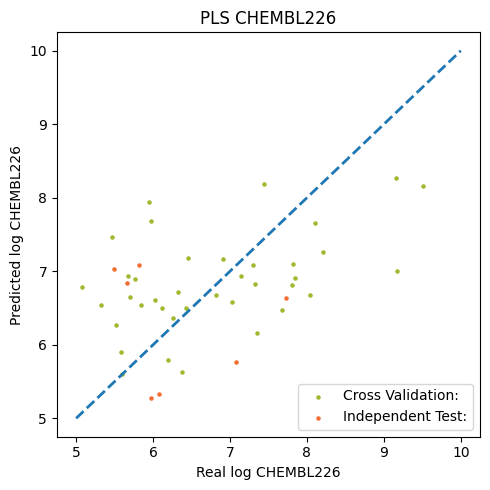

In [7]:
from matplotlib import pyplot as plt
from sklearn import metrics

def QSPR_REG_scatterplot(infolder, targets, models, out=None):
    """
    Function to plot the results of regression models. Plot predicted pX vs real pX. 
    """
    my_cmap = ["#9EBA2E", "#F46E32"]

    plt.figure(figsize=(5, 5))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for m, model in enumerate(models):
            plt.subplot(len(targets),len(models),1 + i*len(models) + m)
            for j, legend in enumerate(['Cross Validation:  ', 'Independent Test:']):
                df = pd.read_table('%s/%s_REG_%s.%s.tsv' % (infolder, model, target, cate[j]))
                plt.scatter(df.Label, df.Score, s=5, label=legend, color=my_cmap[j])
                coef = metrics.r2_score(df.Label, df.Score)
                rmse = metrics.mean_squared_error(df.Label, df.Score, squared=False)
                print('%s %s:(R^2=%.2f, RMSE=%.2f)' % (model, legend,coef,rmse))

            plt.title('%s %s' % (model,target))
            plt.xlabel(f"Real log {target}")
            plt.ylabel(f"Predicted log {target}")
            plt.plot([5, 10], [5, 10], lw=2, linestyle='--')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

QSPR_REG_scatterplot(f"jupyter/qsprmodels/",
                     ["CHEMBL226"], 
                     ["PLS"],
                      out="jupyter/QSPR_REG_scatterplot.png")